In [1]:
from fastai.text.all import *
from pathlib import Path
import pandas as pd
from random import choice
import re

In [2]:
path = Path('../data/')

In [3]:
df = pd.read_csv(path/'mtsamples.csv'); df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two blocks or five flights of stairs. Difficulty with snoring. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago. ,SOCIAL HISTORY:, He is currently single. He has about te...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again. He wants to be able to exercise and play volleyball. Physically, he is sluggish. He gets tired quickly. He does not go out often. When he loses weight he always regains it and he gains back more than he lost. His biggest...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericardial effusion.,6. Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7. PA systolic pressure is 36 mmHg.,DOPPLER: , ,1. Mild mitral and tricuspid regurgitation.,2. Trace aortic and pulmonary regurgitation.","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal lv"
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,"1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consiste

In [4]:
data_lm = TextDataLoaders.from_df(df, path, valid_pct=0.1, seed=7, text_col='transcription', is_lm=True)

/anaconda/envs/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
data_lm.show_batch()

,text,text_
0,"xxbos xxup admission xxup diagnosis : , xxmaj upper respiratory illness with apnea , possible pertussis . ,discharge xxup diagnosis : , xxmaj upper respiratory illness with apnea , possible pertussis . ,complications : , none . ,operations : , none , brief xxup history xxup and xxup physical : , xxmaj this is a one plus - month - old female with respiratory symptoms for approximately a week prior to admission","xxup admission xxup diagnosis : , xxmaj upper respiratory illness with apnea , possible pertussis . ,discharge xxup diagnosis : , xxmaj upper respiratory illness with apnea , possible pertussis . ,complications : , none . ,operations : , none , brief xxup history xxup and xxup physical : , xxmaj this is a one plus - month - old female with respiratory symptoms for approximately a week prior to admission ."
1,injections were done at the site of maximum hip adduction contraction with least amount of stimulus . xxmaj negative drawback for blood was done prior to each injection of phenol . xxmaj the musculocutaneous nerve was identified in the left upper extremity above the brachial pulse using active xxup emg stimulation . xxmaj approximately 5 ml of 5 % phenol was injected in this location . xxmaj injections in this area were,were done at the site of maximum hip adduction contraction with least amount of stimulus . xxmaj negative drawback for blood was done prior to each injection of phenol . xxmaj the musculocutaneous nerve was identified in the left upper extremity above the brachial pulse using active xxup emg stimulation . xxmaj approximately 5 ml of 5 % phenol was injected in this location . xxmaj injections in this area were done
2,"xxup s1 , xxup s2 . xxmaj no murmurs , rubs , or gallops . xxmaj the abdomen is nontender , nondistended , without palpable organomegaly , guarding , rebound , or pulsatile masses . xxmaj skin is warm and dry to the touch with no discernible cyanosis , clubbing or edema . i can radial , dorsalis pedis and posterior tibial pulses . xxmaj the nailbeds on her feet have trophic","s1 , xxup s2 . xxmaj no murmurs , rubs , or gallops . xxmaj the abdomen is nontender , nondistended , without palpable organomegaly , guarding , rebound , or pulsatile masses . xxmaj skin is warm and dry to the touch with no discernible cyanosis , clubbing or edema . i can radial , dorsalis pedis and posterior tibial pulses . xxmaj the nailbeds on her feet have trophic changes"
3,"xxmaj no clubbing or cyanosis . ,cns : benign . ,psychological : normal . ,musculoskeletal : nonsignificant . ,ekg : , xxmaj normal sinus rhythm , incomplete right bundle - branch block . ,laboratory xxup data : , xxup h&h stable . xxup bun and creatinine within normal limits . xxmaj cardiac enzyme profile negative . xxmaj chest x - ray unremarkable . ,impression:,1 . xxmaj lightheaded , dizziness in a 50-year","no clubbing or cyanosis . ,cns : benign . ,psychological : normal . ,musculoskeletal : nonsignificant . ,ekg : , xxmaj normal sinus rhythm , incomplete right bundle - branch block . ,laboratory xxup data : , xxup h&h stable . xxup bun and creatinine within normal limits . xxmaj cardiac enzyme profile negative . xxmaj chest x - ray unremarkable . ,impression:,1 . xxmaj lightheaded , dizziness in a 50-year -"
4,"the site to be preserved . xxmaj using sharp and dull dissection , the soft tissue attachments through the fifth left metatarsal head were mobilized . xxmaj the lateral and plantar aspect of the fifth left metatarsal head were adequately exposed and using the sagittal saw a lateral and plantar condylectomy of the fifth left metatarsal head were then achieved . xxmaj the bony prominences were removed and passed off the operating","site to be preserved . xxmaj using sharp and dull dissection , the soft tissue attachments through the fifth left metatarsal head were mobilized . xxmaj the lateral and plantar aspect of the fifth left metatarsal head were adequately exposed and using the sagittal saw a lateral and pla

In [6]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.2, drop_mult=0.3)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.02754228748381138)

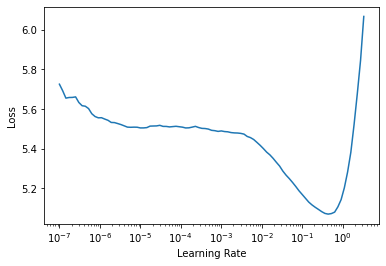

In [7]:
learn_lm.lr_find()

In [8]:
learn_lm.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.217184,2.981575,0.443964,19.718849,05:15


In [9]:
learn_lm.save('/home/advaitmb/notebooks/projects/PreDiction/models/medical/1epoch')

Path('/home/advaitmb/notebooks/projects/PreDiction/models/medical/1epoch.pth')

In [19]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.883165,3.939514,0.345794,51.393600,06:17
1,3.383141,3.321693,0.404654,27.707224,06:20
2,2.822211,2.696461,0.480261,14.827161,06:19


In [10]:
learn_lm.predict("The patient", n_words=20)

"The patient 's Neurology assessment , the patient was called including Dr . y when asked to grasp the entire"

In [11]:
def beam_search(learn, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
    learn.model.reset()
    learn.model.eval()
    idx = learn.dls.test_dl([text]).items[0][None]
    nodes = None
    nodes = idx.clone()
    scores = idx.new_zeros(1).float()
    if no_unk: unk_idx = learn.dls.vocab.index(UNK)
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(learn.model(idx)[0][:,-1], dim=-1)
            if no_unk: out[:, unk_idx] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            learn.hidden = [(h[0][:,indices_idx[sort_idx],:],h[1][:,indices_idx[sort_idx],:]) for h in learn.model[0].hidden]
            idx = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        num = learn.dls.train_ds.numericalize
        tokens = [num.vocab[i] for i in nodes[node_idx][1:] if num.vocab[i] not in [BOS, PAD]]
        sep = learn.dls.train_ds.tokenizer.sep
        return sep.join(decoder(tokens))

In [13]:
learn_des = load_learner('/home/advaitmb/notebooks/projects/PreDiction/models/design/4epochslearner.pkl')
learn_hum = load_learner('/home/advaitmb/notebooks/projects/PreDiction/models/5epochslearner_v2.pkl')

In [17]:
text = 'We think'


In [18]:
learn_hum.predict(text = text , n_words = 10, temperature = 0.7),'/n', learn_des.predict(text = text , n_words = 10, temperature = 0.7), learn_lm.predict(text = text , n_words = 10, temperature = 0.7)

('We think the President of the United States of',
 '/n',
 'We think that Web search engines are concerned with finding and',
 'We think this is a little bit of better . We')